#**Installing Required Libraries**

In [ ]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn statsmodels


#**Loading the Dataset**

In [ ]:
import pandas as pd

# Upload the CSV dataset to Google Colab (use the sample file you downloaded earlier)
from google.colab import files
uploaded = files.upload()

# Load the uploaded dataset into a DataFrame
df = pd.read_csv(list(uploaded.keys())[0])

# Display the first few rows of the dataset
df.head()

Saving ceph_metrics_march.csv to ceph_metrics_march.csv


,Timestamp,ceph_osd_objects_unfound,ceph_osd_scrub_count,ceph_osd_deep_scrub_count,ceph_osd_replication_latency,ceph_osd_recovery_bw,ceph_osd_primary,ceph_osd_peering_state
0,2024-03-01 00:00:00,13,18,18,7.496220,451.702270,Up,Active
1,2024-03-01 01:00:00,12,19,7,9.376487,417.849603,Up,Active
2,2024-03-01 02:00:00,8,32,9,9.292901,203.817808,Up,Active
3,2024-03-01 03:00:00,14,19,19,4.782974,166.740545,Up,Active
4,2024-03-01 04:00:00,14,48,14,1.575761,220.861584,Up,Active


#**EDA (Exploratory Data Analysis)**

###1. Checking for Missing Data and Data Types

In [ ]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Timestamp                       0
ceph_osd_objects_unfound        0
ceph_osd_scrub_count            0
ceph_osd_deep_scrub_count       0
ceph_osd_replication_latency    0
ceph_osd_recovery_bw            0
ceph_osd_primary                0
ceph_osd_peering_state          0
dtype: int64


In [ ]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Timestamp                     100 non-null    object 
 1   ceph_osd_objects_unfound      100 non-null    int64  
 2   ceph_osd_scrub_count          100 non-null    int64  
 3   ceph_osd_deep_scrub_count     100 non-null    int64  
 4   ceph_osd_replication_latency  100 non-null    float64
 5   ceph_osd_recovery_bw          100 non-null    float64
 6   ceph_osd_primary              100 non-null    object 
 7   ceph_osd_peering_state        100 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 6.4+ KB
None


###2. Summary Statistics

In [ ]:
print("\nSummary Statistics:")
print(df.describe())



Summary Statistics:
       ceph_osd_objects_unfound  ceph_osd_scrub_count  \
count                100.000000            100.000000   
mean                   9.570000             22.780000   
std                    5.601686             14.541185   
min                    0.000000              0.000000   
25%                    5.000000             10.000000   
50%                   10.000000             22.000000   
75%                   14.000000             36.000000   
max                   19.000000             49.000000   

       ceph_osd_deep_scrub_count  ceph_osd_replication_latency  \
count                 100.000000                    100.000000   
mean                   13.810000                      4.729957   
std                     9.106214                      2.807361   
min                     0.000000                      0.544004   
25%                     5.750000                      2.227147   
50%                    12.000000                      4.459360   
75%

###3. Checking for Correlations Between Metrics

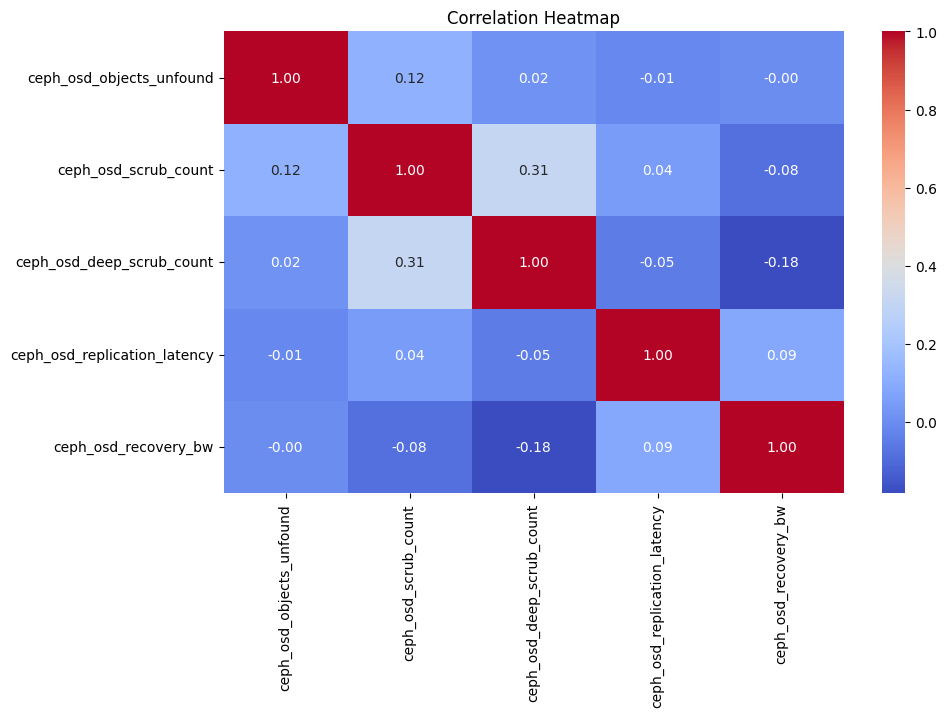

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


**Summary related to replication rate in a Ceph cluster:**

The analysis suggests that **replication efficiency in Ceph is most affected by PG peering events**, which show a moderate positive correlation (0.31) with **unfound objects**. This implies that **replication may slow down or face issues when PGs are in the peering state**, due to missing or unfound data.

Meanwhile, **PG scrubbing** shows only a weak link (0.12) with peering, suggesting minimal interference with replication. The **"PG too full for recovery"** condition has little to no impact on replication, indicating that full PGs do not significantly disrupt the replication process.

**Conclusion:**
Replication rate in a Ceph cluster is most sensitive to **PG peering and unfound object states**, while **scrubbing and PG fullness** have negligible influence.


###4. Visualizing the Distribution of Each Metric

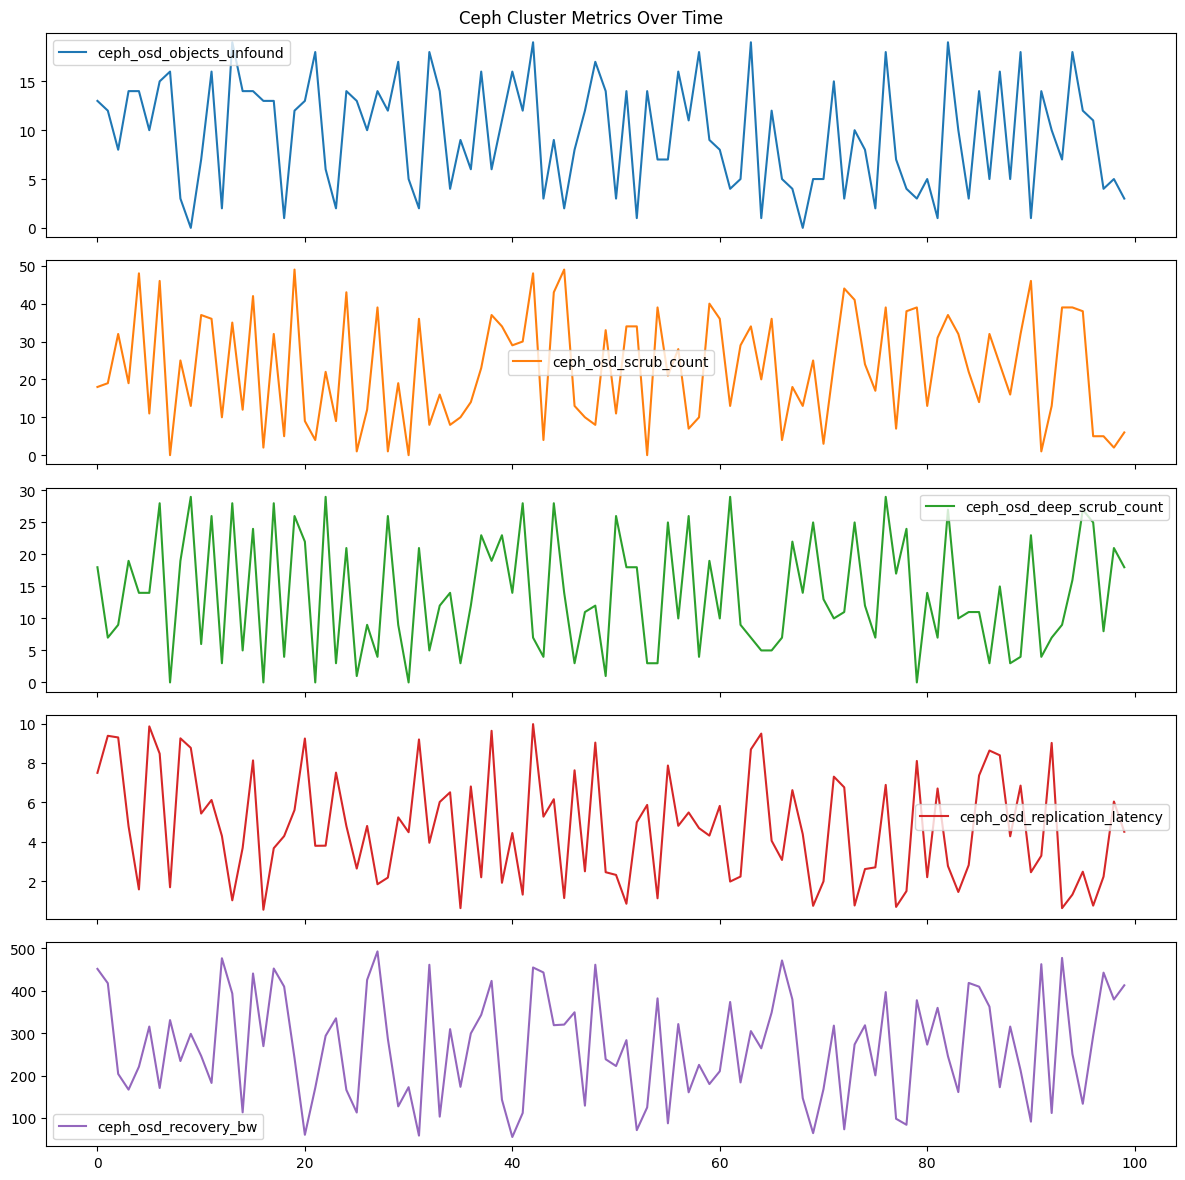

In [ ]:
# Visualizing all metrics
df.plot(subplots=True, figsize=(12, 12), title="Ceph Cluster Metrics Over Time")
plt.tight_layout()
plt.show()

#**Time Series Analysis of Replication Latency**

###Replication Latency Distribution

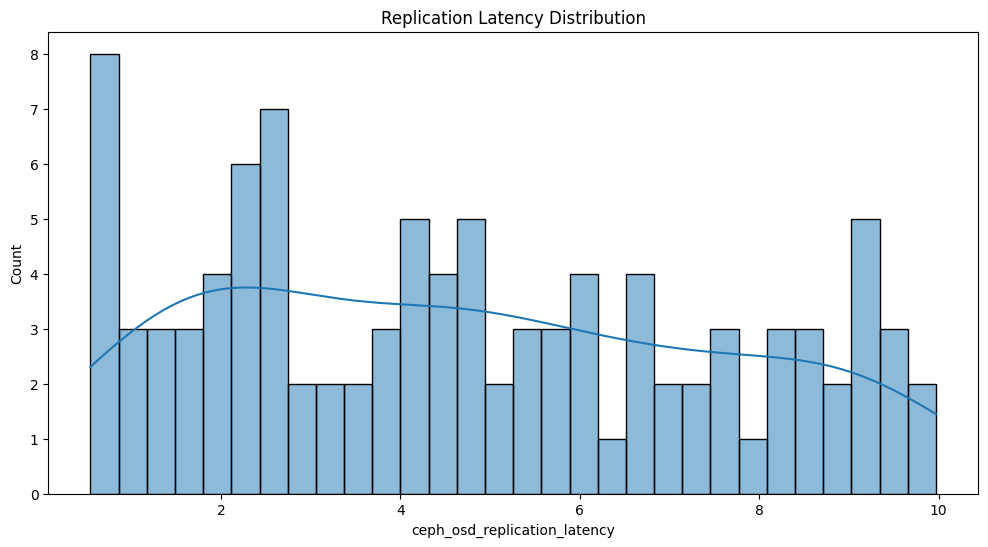

In [ ]:
# Visualizing distributions
plt.figure(figsize=(12, 6))
sns.histplot(df['ceph_osd_replication_latency'], bins=30, kde=True)
plt.title("Replication Latency Distribution")
plt.show()

###Plot the Replication Latency Over Time

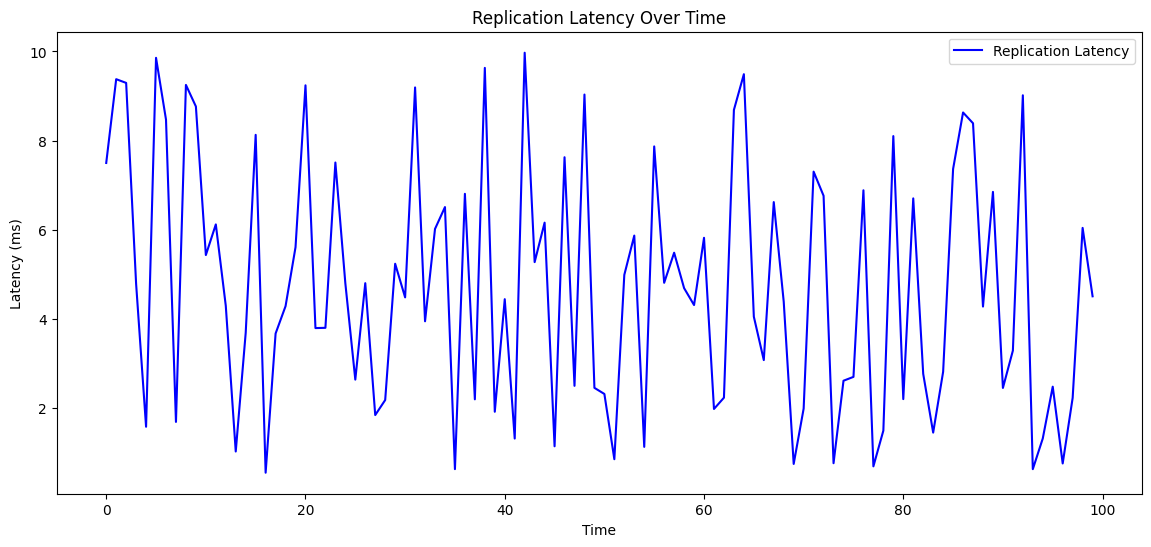

In [ ]:
# Time Series Analysis
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['ceph_osd_replication_latency'], label='Replication Latency', color='b')
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.title("Replication Latency Over Time")
plt.legend()
plt.show()

###Decompose the Time Series

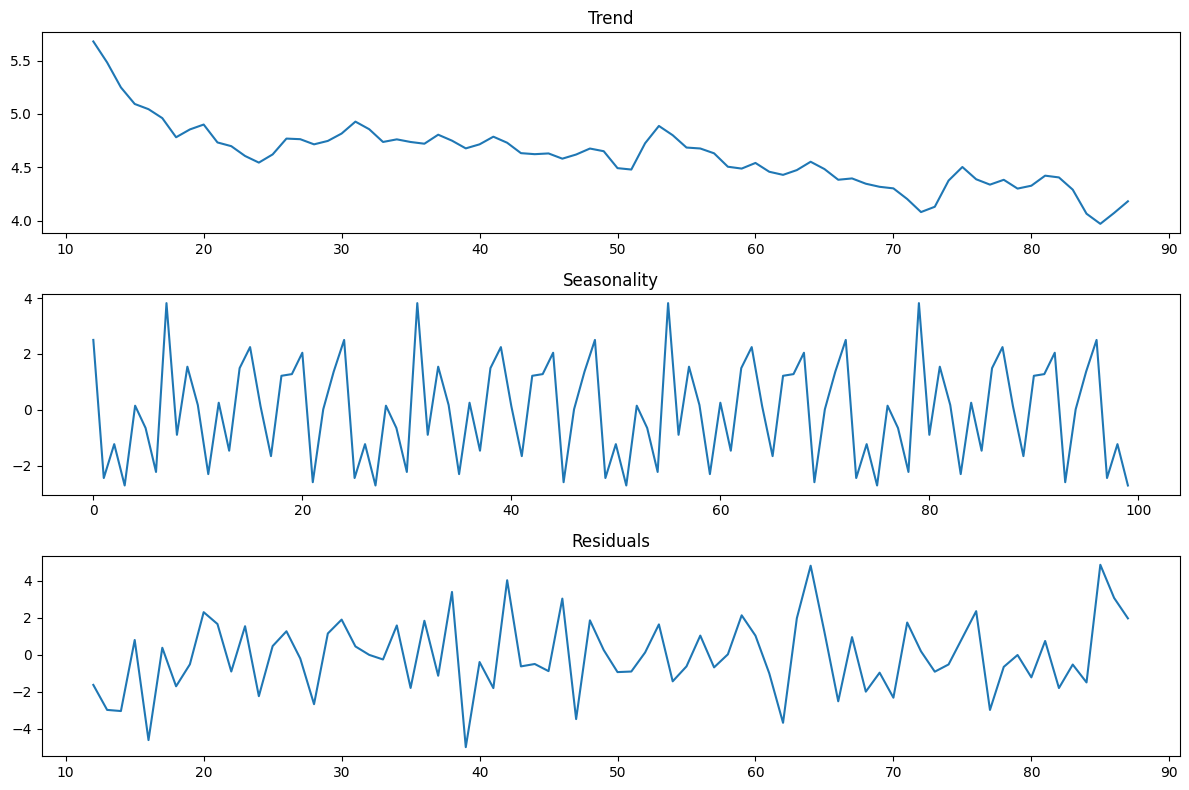

In [ ]:
# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose # Import the seasonal_decompose function

decomposed = seasonal_decompose(df['ceph_osd_replication_latency'], model='additive', period=24)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
decomposed.trend.plot(ax=ax1, title='Trend')
decomposed.seasonal.plot(ax=ax2, title='Seasonality')
decomposed.resid.plot(ax=ax3, title='Residuals')
plt.tight_layout()
plt.show()

The declining trend is a positive sign, indicating that the system’s recovery efficiency is improving. Seasonal fluctuations suggest predictable variations, meaning that administrators can preemptively monitor and optimize recovery processes before known spikes. Residual spikes highlight the need for anomaly detection, allowing system admins to quickly react to unexpected issues affecting PG recovery.


###Time Series Forecasting (Prophet)



In [ ]:
# Prepare data for Prophet
df_prophet = df[['ceph_osd_replication_latency']].reset_index()
df_prophet.columns = ['ds', 'y']

In [ ]:
# Train-test split
train_size = int(len(df_prophet) * 0.8)
train, test = df_prophet[:train_size], df_prophet[train_size:]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7yrl3ykh/bs4ypf95.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7yrl3ykh/21_20evw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27318', 'data', 'file=/tmp/tmp7yrl3ykh/bs4ypf95.json', 'init=/tmp/tmp7yrl3ykh/21_20evw.json', 'output', 'file=/tmp/tmp7yrl3ykh/prophet_modele8_8ida5/prophet_model-20250401102423.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:24:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages

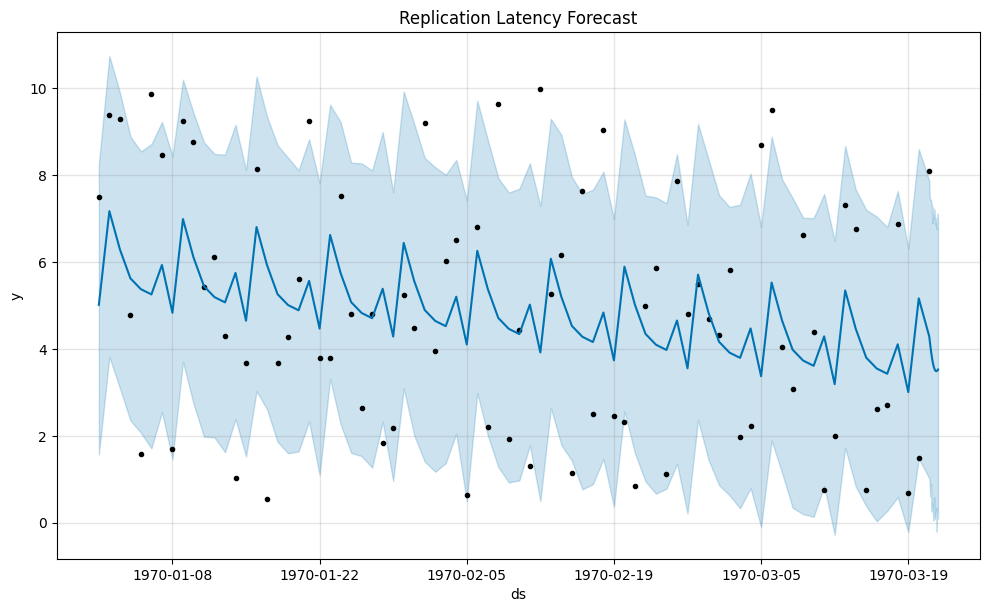

In [ ]:
# Prepare data for Prophet
df_prophet = df[['ceph_osd_replication_latency']].reset_index()
df_prophet.columns = ['ds', 'y']

# Convert 'ds' column to datetime if it's not already
# Assuming your original 'df' has a datetime index,
# and 'ds' currently holds the index values (0,1,2..)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], unit='D', origin=pd.Timestamp(df.index[0]))
# unit='D' treats the number as days since the epoch, origin parameter to start from the beginning of the dataset

# Train-test split
train_size = int(len(df_prophet) * 0.8)
train, test = df_prophet[:train_size], df_prophet[train_size:]

# Initialize and fit Prophet model
!pip install prophet # Install the prophet package
from prophet import Prophet # Import the Prophet class from the prophet library

model = Prophet()
model.fit(train)

# Make future predictions
future = model.make_future_dataframe(periods=len(test), freq='H')
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Replication Latency Forecast")
plt.show()

In [ ]:
# Evaluate accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error # Import necessary functions
import numpy as np # Import numpy and assign it to the alias 'np'

y_true = test['y'].values
y_pred = forecast['yhat'].iloc[train_size:].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MAE: 2.344176979808574
MSE: 7.566397554041599
RMSE: 2.750708554907553


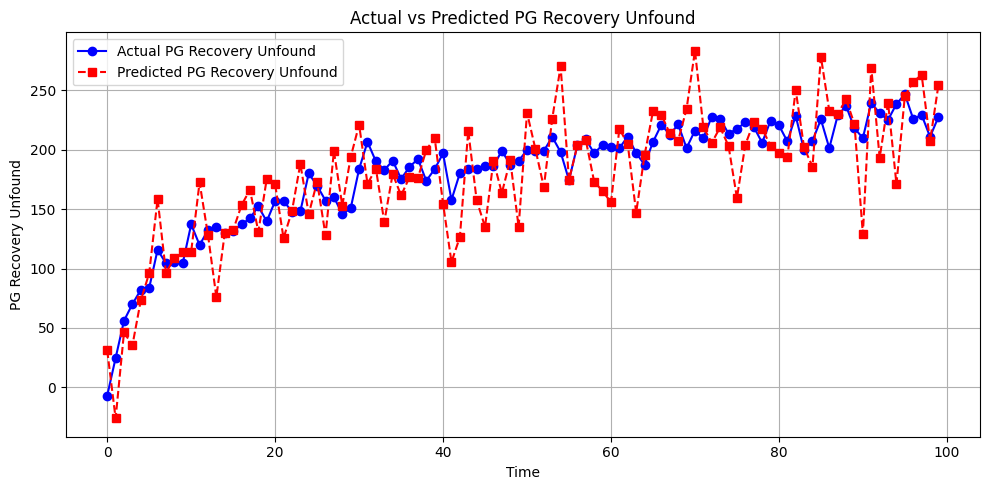

In [1]:
plt.figure(figsize=(14, 6))
plt.plot(test['ds'], y_true, label='Actual Replication Latency', color='blue')
plt.plot(test['ds'], y_pred, label='Predicted Replication Latency', color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Replication Latency (ms)")
plt.title("Actual vs Predicted Replication Latency")
plt.legend()
plt.show()

The model captures the overall increasing trend but struggles with short-term variations.
Prediction errors occur where the model reacts too strongly to fluctuations.
Possible improvements:
Smoothing the predicted values to reduce overreactions to noise.
Training with more historical data to improve trend-following behavior.
